<hr/>

# **Predicting Sentiment from Clothing Reviews**

[**Burhan Y. Kiyakoglu**](https://www.kaggle.com/burhanykiyakoglu)
<hr/>

<span id="0"></span>
<font color=green>

1. [Overview](#1)
1. [Importing Modules and Reading the Dataset](#2)
1. [Adding the Word Counts to the Dataframe and Finding out How Many Times Some Words Were Used ](#3)
1. [Demonstrating the Densities of Class Names, Some Selected Words and All Words in the Reviews By Using WordCloud](#4)
1. [Viewing the Relation Between Ratings, Class Names and Age](#5)
1. [Building a Sentiment Classifier](#6)
   * [Logistic Regression ](#7)
   * [Naive Bayes](#8)
   * [Support Vector Machine (SVM)](#9)
   * [Neural Network](#10)
1. [Evaluating Models](#11) 
   * [Adding Results to the Dataframe](#12)
   * [ROC Curves and AUC](#13)
   * [Confusion Matrices](#14)
   * [Precision - Recall - F1-Score](#15)
1. [Conclusion](#16) 

# <span id="1"></span> Overview
<hr/>
Welcome to my Kernel! In this kernel, I use various methods and try to predict the customer sentiment from reviews. As you can guess, there are various methods to suceed this and each method has pros and cons. I think **Naive Bayes is one of the most important methods in text mining because it is the fastest**. However, if we do not have a very large dataset or have high CPU power, the others might be useful too. 

Here, I started with examining the data and use some charts to reach more insights. Afterwards, I applied different models and compared them from various aspects.

If you have a question or feedback, do not hesitate to write and if you like this kernel, please <b><font color="red">do not forget to </font><font color="green">UPVOTE </font></b> 🙂 
<br/>
<img src="https://i.imgur.com/1tHbhZ4.jpg" title="source: imgur.com"/>

# <span id="2"></span> Importing Modules and Reading the Dataset
#### [Return Contents](#0)
<hr/>

In order to make some analysis, we need to set our environment up. To do this, I firstly imported some modules and read the data. The below output is the head of the data but if you want to see more details, you might try removing ***#*** signs in front of the ***df.describe()*** and ***df.info()***.  

Further, I decided that I do not need some columns and defined a new dataset which just has the columns I used. 

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import sklearn.metrics as mt
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
 
df1 = pd.read_csv('./data/Womens Clothing E-Commerce Reviews.csv')
df = df1[['Review Text','Rating','Class Name','Age']]
#df1.info()
#df1.describe()
df1.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


# <span id="3"></span> Adding the Word Counts to the Dataframe and Finding out How Many Times Some Words Were Used 
#### [Return Contents](#0)
<hr/>

Adding the word counts to a dataframe is a very good practice because we might use these counts to reach some useful information. To do this, I defined the function ***wordcounts***.

In [2]:
# fill NA values by space
df['Review Text'] = df['Review Text'].fillna('')

# CountVectorizer() converts a collection 
# of text documents to a matrix of token counts
vectorizer = CountVectorizer()
# assign a shorter name for the analyze
# which tokenizes the string
analyzer = vectorizer.build_analyzer()

def wordcounts(s):
    c = {}
    # tokenize the string and continue, if it is not empty
    if analyzer(s):
        d = {}
        # find counts of the vocabularies and transform to array 
        w = vectorizer.fit_transform([s]).toarray()
        # vocabulary and index (index of w)
        vc = vectorizer.vocabulary_
        # items() transforms the dictionary's (word, index) tuple pairs
        for k,v in vc.items():
            d[v]=k # d -> index:word 
        for index,i in enumerate(w[0]):
            c[d[index]] = i # c -> word:count
    return  c

# add new column to the dataframe
df['Word Counts'] = df['Review Text'].apply(wordcounts)
df.head()

,Review Text,Rating,Class Name,Age,Word Counts
0,Absolutely wonderful - silky and sexy and comf...,4,Intimates,33,"{'absolutely': 1, 'and': 2, 'comfortable': 1, ..."
1,Love this dress! it's sooo pretty. i happene...,5,Dresses,34,"{'am': 1, 'and': 2, 'bc': 2, 'be': 1, 'below':..."
2,I had such high hopes for this dress and reall...,3,Dresses,60,"{'and': 3, 'be': 1, 'bottom': 1, 'but': 2, 'ch..."
3,"I love, love, love this jumpsuit. it's fun, fl...",5,Pants,50,"{'and': 1, 'but': 1, 'compliments': 1, 'every'..."
4,This shirt is very flattering to all due to th...,5,Blouses,47,"{'adjustable': 1, 'all': 1, 'and': 1, 'any': 1..."


# <span id="4"></span>  Demonstrating the Densities of Class Names, Some Selected Words and All Words in the Reviews By Using WordCloud 
#### [Return Contents](#0)
<hr/>

In this section, I demonstrated the word densities which can be very informative. First, I selected some words which show the customer sentiments like love, hate, fantastic or regret. Second, since we do not know the product names, I decided to check the product class names. By doing this, we may at least learn the most prefered classes. Further, I thought that looking at the densities of all words in the reviews might be interesting. Lastly, I used the *WordCloud* module and printed the first five lines of the tables which shows the word counts for the selected words and the class names. 

It can be observed from the below figures and tables that positive words as love, great, super were used more. When we look at the classes, customers mostly prefered dress, knits and blouses. We may also see that dress and love are in the freequently used words within all reviews. 

Selected Words
love     8951
great    6117
super    1726
happy     705
glad      614
dtype: int64

Class Names
Dresses     6319
Knits       4843
Blouses     3097
Sweaters    1428
Pants       1388
Name: Class Name, dtype: int64


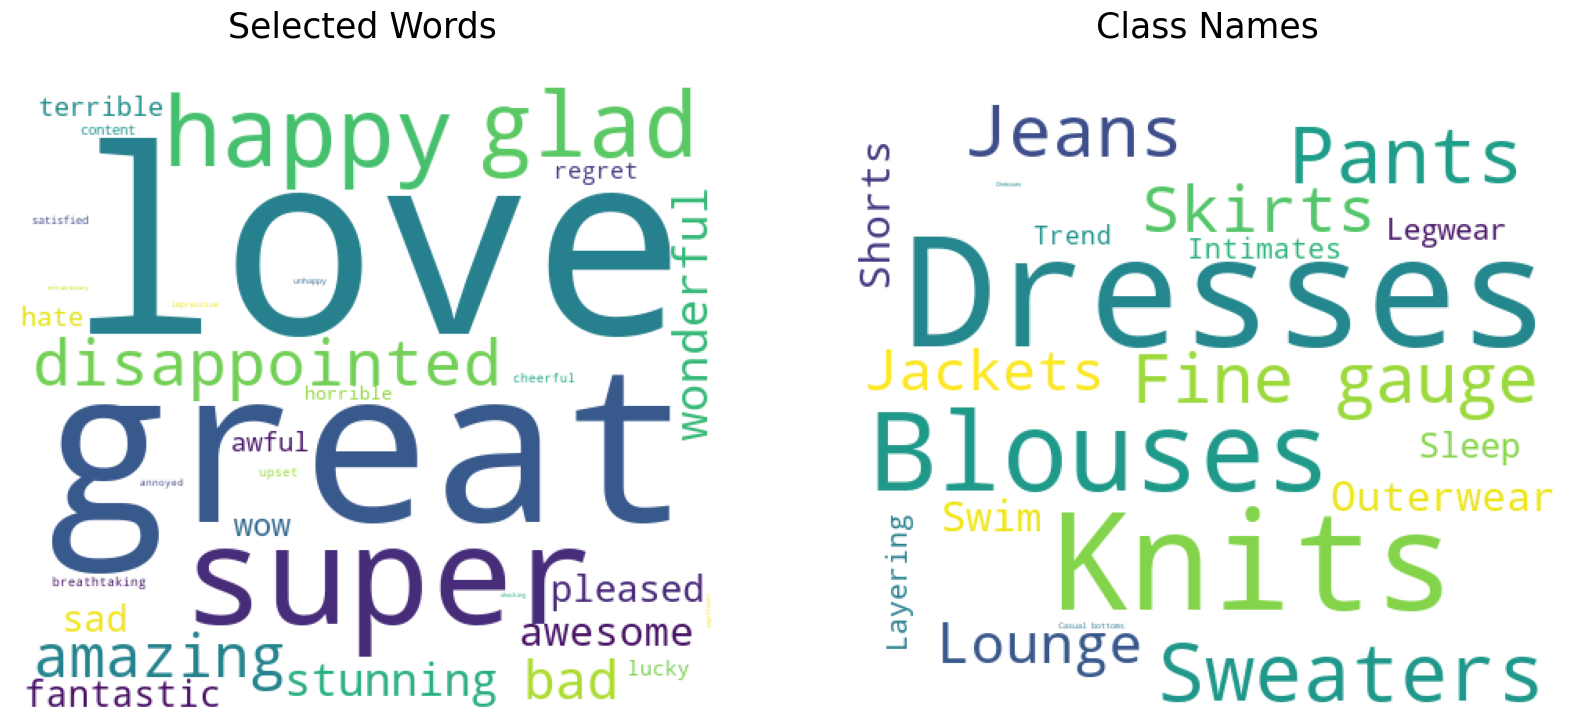

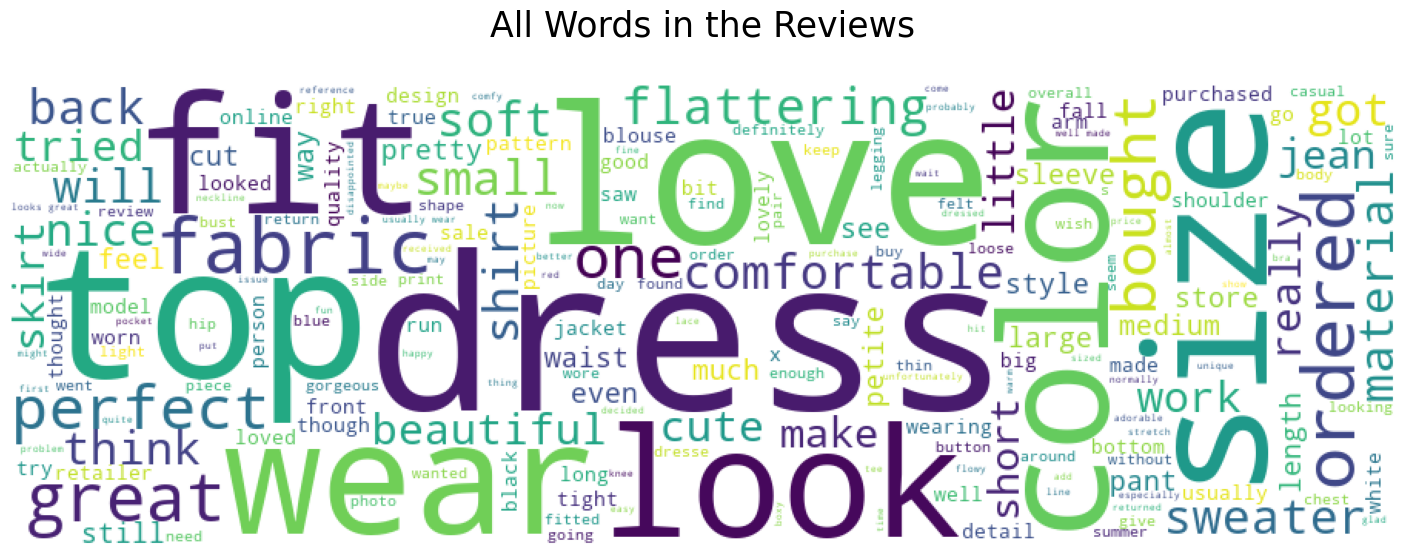

In [3]:
# selecting some words to examine detailed 
selectedwords = ['awesome','great','fantastic','extraordinary','amazing','super',
                 'magnificent','stunning','impressive','wonderful','breathtaking',
                 'love','content','pleased','happy','glad','satisfied','lucky',
                 'shocking','cheerful','wow','sad','unhappy','horrible','regret',
                 'bad','terrible','annoyed','disappointed','upset','awful','hate']

def selectedcount(dic,word):
    if word in dic:
        return dic[word]
    else:
        return 0
    
dfwc = df.copy()  
for word in selectedwords:
    dfwc[word] = dfwc['Word Counts'].apply(selectedcount,args=(word,))
    
word_sum = dfwc[selectedwords].sum()
print('Selected Words')
print(word_sum.sort_values(ascending=False).iloc[:5])

print('\nClass Names')
print(df['Class Name'].fillna("Empty").value_counts().iloc[:5])

fig, ax = plt.subplots(1,2,figsize=(20,10))
wc0 = WordCloud(background_color='white',
                      width=450,
                      height=400 ).generate_from_frequencies(word_sum)

cn = df['Class Name'].fillna(" ").value_counts()
wc1 = WordCloud(background_color='white',
                      width=450,
                      height=400 
                     ).generate_from_frequencies(cn)

ax[0].imshow(wc0)
ax[0].set_title('Selected Words\n',size=25)
ax[0].axis('off')

ax[1].imshow(wc1)
ax[1].set_title('Class Names\n',size=25)
ax[1].axis('off')

rt = df['Review Text']
plt.subplots(figsize=(18,6))
wordcloud = WordCloud(background_color='white',
                      width=900,
                      height=300
                     ).generate(" ".join(rt))
plt.imshow(wordcloud)
plt.title('All Words in the Reviews\n',size=25)
plt.axis('off')
plt.show()

 # <span id="5"></span> Viewing the Relation Between Rating, Class Name and Age  
#### [Return Contents](#0)
<hr/>

I thought that examining the relation between the rating, class names and age might be good because some age groups may always give low ratings or make negative reviews or prefer the products in the same class. To examine this relationship, I used the below dynamic charts. 

In [4]:
df1=df['Rating'].value_counts().to_frame()
avgdf1 = df.groupby('Class Name').agg({'Rating': np.average})
avgdf2 = df.groupby('Class Name').agg({'Age': np.average})
avgdf3 = df.groupby('Rating').agg({'Age': np.average})

trace1 = go.Bar(
    x=avgdf1.index,
    y=round(avgdf1['Rating'],2),
    marker=dict(
        color=avgdf1['Rating'],
        colorscale = 'RdBu')
)

trace2 = go.Bar(
    x=df1.index,
    y=df1.Rating,
    marker=dict(
        color=df1['Rating'],
        colorscale = 'RdBu')
)

trace3 = go.Bar(
    x=avgdf2.index,
    y=round(avgdf2['Age'],2),
    marker=dict(
        color=avgdf2['Age'],
        colorscale = 'RdBu')
)

trace4 = go.Bar(
    x=avgdf3.index,
    y=round(avgdf3['Age'],2),
    marker=dict(
        color=avgdf3['Age'],
        colorscale = 'Reds')
)

fig = tools.make_subplots(rows=2, cols=2, print_grid=False)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 2)

fig['layout']['xaxis1'].update(title='Class')
fig['layout']['yaxis1'].update(title='Average Rating')
fig['layout']['xaxis2'].update(title='Rating')
fig['layout']['yaxis2'].update(title='Count')
fig['layout']['xaxis3'].update(title='Class')
fig['layout']['yaxis3'].update(title='Average Age of the Reviewers')
fig['layout']['xaxis4'].update(title='Rating')
fig['layout']['yaxis4'].update(title='Average Age of the Reviewers')

fig['layout'].update(height=800, width=900,showlegend=False)
fig.update_layout({'plot_bgcolor':'rgba(0,0,0,0)',
                   'paper_bgcolor':'rgba(0,0,0,0)'})
#fig['layout'].update(plot_bgcolor='rgba(0,0,0,0)')
#fig['layout'].update(paper_bgcolor='rgba(0,0,0,0)')
py.iplot(fig)

It seems that most of the ratings are positive and the average rating between the classes looks close. On the other hand, when we look at ages, average age does not change significantly according to the rating. Also, average age changes slightly between class names except casual bottoms. We can disregard casual bottoms because the below chart shows that there are just two reviews and making an inference will not be right.

In [5]:
cv = df['Class Name'].value_counts()

trace = go.Scatter3d( x = avgdf1.index,
                      y = avgdf1['Rating'],
                      z = cv[avgdf1.index],
                      mode = 'markers',
                      marker = dict(size=10,color=avgdf1['Rating']),
                      hoverinfo ="text",
                      text="Class: "+avgdf1.index+" \ Average Rating: "+avgdf1['Rating'].map(' {:,.2f}'.format).apply(str)+" \ Number of Reviewers: "+cv[avgdf1.index].apply(str)
                      )

data = [trace]
layout = go.Layout(title="Average Rating & Class & Number of Reviewers",
                   scene = dict(
                    xaxis = dict(title='Class'),
                    yaxis = dict(title='Average Rating'),
                    zaxis = dict(title='Number of Sales'),),
                   margin = dict(l=30, r=30, b=30, t=30))
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)
#plt.savefig('3D_Scatter.png')

 # <span id="6"></span> Building a Sentiment Classifier
#### [Return Contents](#0)
<hr/>

Since we do not have a column which shows the sentiment as positive or negative in the dataset, I defined a new sentiment column. To do this, I assumed the reviews which has **4 or higher ** rating as **positive (True in the new dataframe)** and **2 or lower** rating as **negative (False in the new dataframe)**. Also, I did not include the lines that has **neutral** ratings which are equal to **3**. Following that, I splitted the data as training and test sets.

In [6]:
# Rating of 4 or higher -> positive, while the ones with 
# Rating of 2 or lower -> negative 
# Rating of 3 -> neutral
df = df[df['Rating'] != 3]
df['Sentiment'] = df['Rating'] >=4
df.head()

# split data
train_data,test_data = train_test_split(df,train_size=0.8,random_state=0)
# select the columns and 
# prepare data for the models 
X_train = vectorizer.fit_transform(train_data['Review Text'])
y_train = train_data['Sentiment']
X_test = vectorizer.transform(test_data['Review Text'])
y_test = test_data['Sentiment']

Then, I fitted the models one by one. Since, some of them take too much time, running each of them in different cells is a better choice.   

## <span id="7"></span> Logistic Regression

In [7]:
start=dt.datetime.now()
lr = LogisticRegression()
lr.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:00:00.378622


## <span id="8"></span> Naive Bayes

In [8]:
start=dt.datetime.now()
nb = MultinomialNB()
nb.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:00:00.004486


## <span id="9"></span> Support Vector Machine (SVM)

In [9]:
start=dt.datetime.now()
svm = SVC()
svm.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:00:24.316853


## <span id="10"></span> Neural Network

In [10]:
start=dt.datetime.now()
nn = MLPClassifier()
nn.fit(X_train,y_train)
print('Elapsed time: ',str(dt.datetime.now()-start))

Elapsed time:  0:01:01.334207


# <span id="11"></span> Evaluating Models
#### [Return Contents](#0)
<hr/>

## <span id="12"></span> Adding Results to the Dataframe

At first, I added the prediction results to my training data. However, if you want to observe the prediction probabilies, you might use the commented out code.

In [11]:
# define a dataframe for the prediction probablities of the models
#df1 = train_data.copy()
#df1['Logistic Regression'] = lr.predict_proba(X_train)[:,1]
#df1['Naive Bayes'] = nb.predict_proba(X_train)[:,1]
#df1['SVM'] = svm.decision_function(X_train)
#df1['Neural Network'] = nn.predict_proba(X_train)[:,1]
#df1=df1.round(2)
#df1.head()

# define a dataframe for the predictions
df2 = train_data.copy()
df2['Logistic Regression'] = lr.predict(X_train)
df2['Naive Bayes'] = nb.predict(X_train)
df2['SVM'] = svm.predict(X_train)
df2['Neural Network'] = nn.predict(X_train)
df2.head()

,Review Text,Rating,Class Name,Age,Word Counts,Sentiment,Logistic Regression,Naive Bayes,SVM,Neural Network
19218,I love this dress's gentle blue lace. the silh...,5,Dresses,35,"{'and': 1, 'as': 1, 'blue': 1, 'chest': 1, 'dr...",True,True,True,True,True
3530,Beautiful choice...beautiful fit for my daught...,5,Knits,51,"{'beautiful': 2, 'body': 1, 'choice': 1, 'daug...",True,True,True,True,True
15663,"If you are shaped anything like me, you will h...",4,Dresses,25,"{'am': 1, 'and': 2, 'anything': 1, 'are': 1, '...",True,True,True,True,True
21310,This top is so cute and of spectacular quality...,5,Blouses,33,"{'10': 1, '34c': 1, 'all': 1, 'almost': 1, 'an...",True,True,True,True,True
15154,First saw this poncho on a petite blog and aft...,5,Sweaters,56,"{'after': 1, 'and': 5, 'below': 1, 'blog': 1, ...",True,True,True,True,True


## <span id="13"></span> ROC Curves and AUC

I started my evaluation with ROC curve and AUC. As you may observe below, results look pretty good but it does not give much insight. To decide which model is the best we must also examine other evaluation metrics.

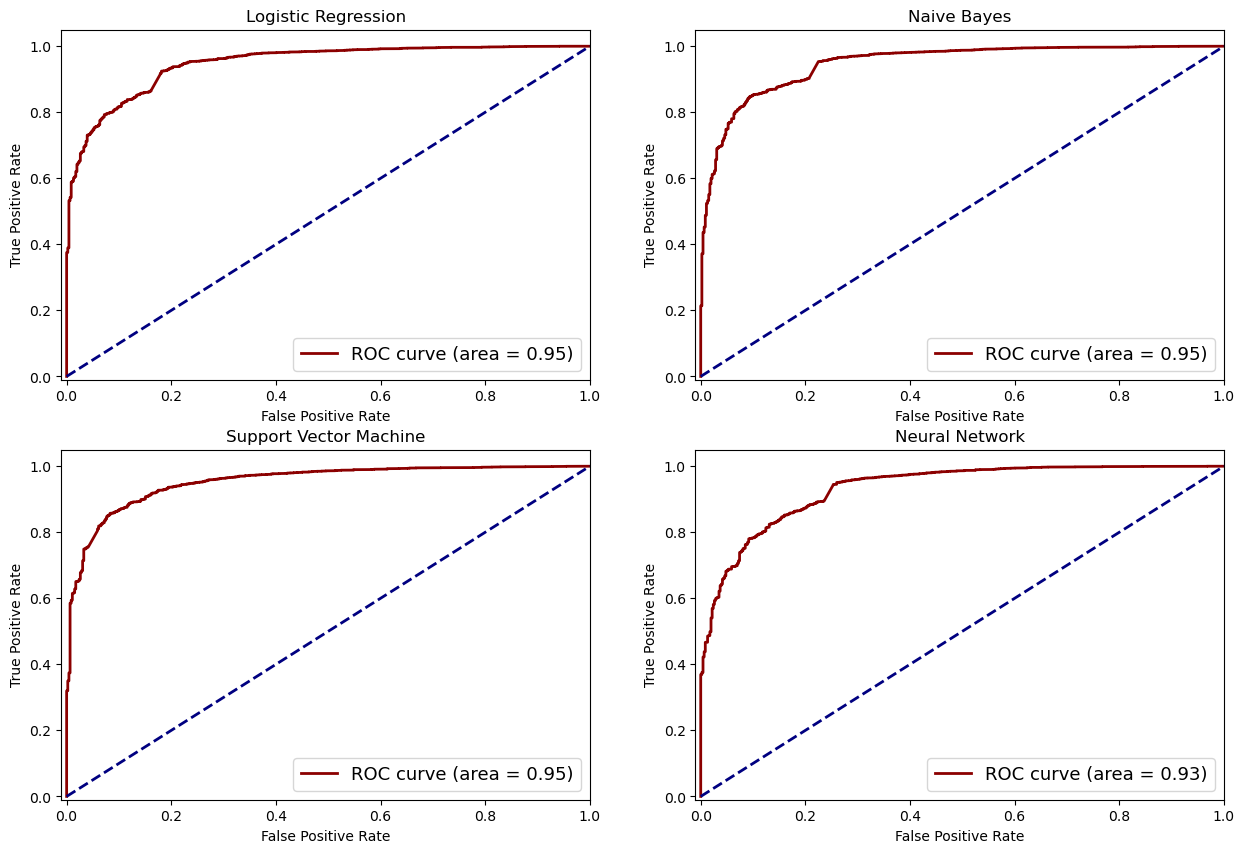

In [12]:
pred_lr = lr.predict_proba(X_test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(y_test,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

pred_nb = nb.predict_proba(X_test)[:,1]
fpr_nb,tpr_nb,_ = roc_curve(y_test.values,pred_nb)
roc_auc_nb = auc(fpr_nb,tpr_nb)

pred_svm = svm.decision_function(X_test)
fpr_svm,tpr_svm,_ = roc_curve(y_test.values,pred_svm)
roc_auc_svm = auc(fpr_svm,tpr_svm)

pred_nn = nn.predict_proba(X_test)[:,1]
fpr_nn,tpr_nn,_ = roc_curve(y_test.values,pred_nn)
roc_auc_nn = auc(fpr_nn,tpr_nn)

f, axes = plt.subplots(2, 2,figsize=(15,10))
axes[0,0].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_lr))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Logistic Regression')
axes[0,0].legend(loc='lower right', fontsize=13)

axes[0,1].plot(fpr_nb, tpr_nb, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nb))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Naive Bayes')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_svm, tpr_svm, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_svm))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Support Vector Machine')
axes[1,0].legend(loc='lower right', fontsize=13)

axes[1,1].plot(fpr_nn, tpr_nn, color='darkred', lw=2, label='ROC curve (area = {:0.2f})'.format(roc_auc_nn))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='False Positive Rate', ylabel = 'True Positive Rate', title = 'Neural Network')
axes[1,1].legend(loc='lower right', fontsize=13);

## <span id="14"></span> Confusion Matrices

To reach more information, I also used confusion matrices. It can be seen that SVM does not give healthy results although it has high ROC values.

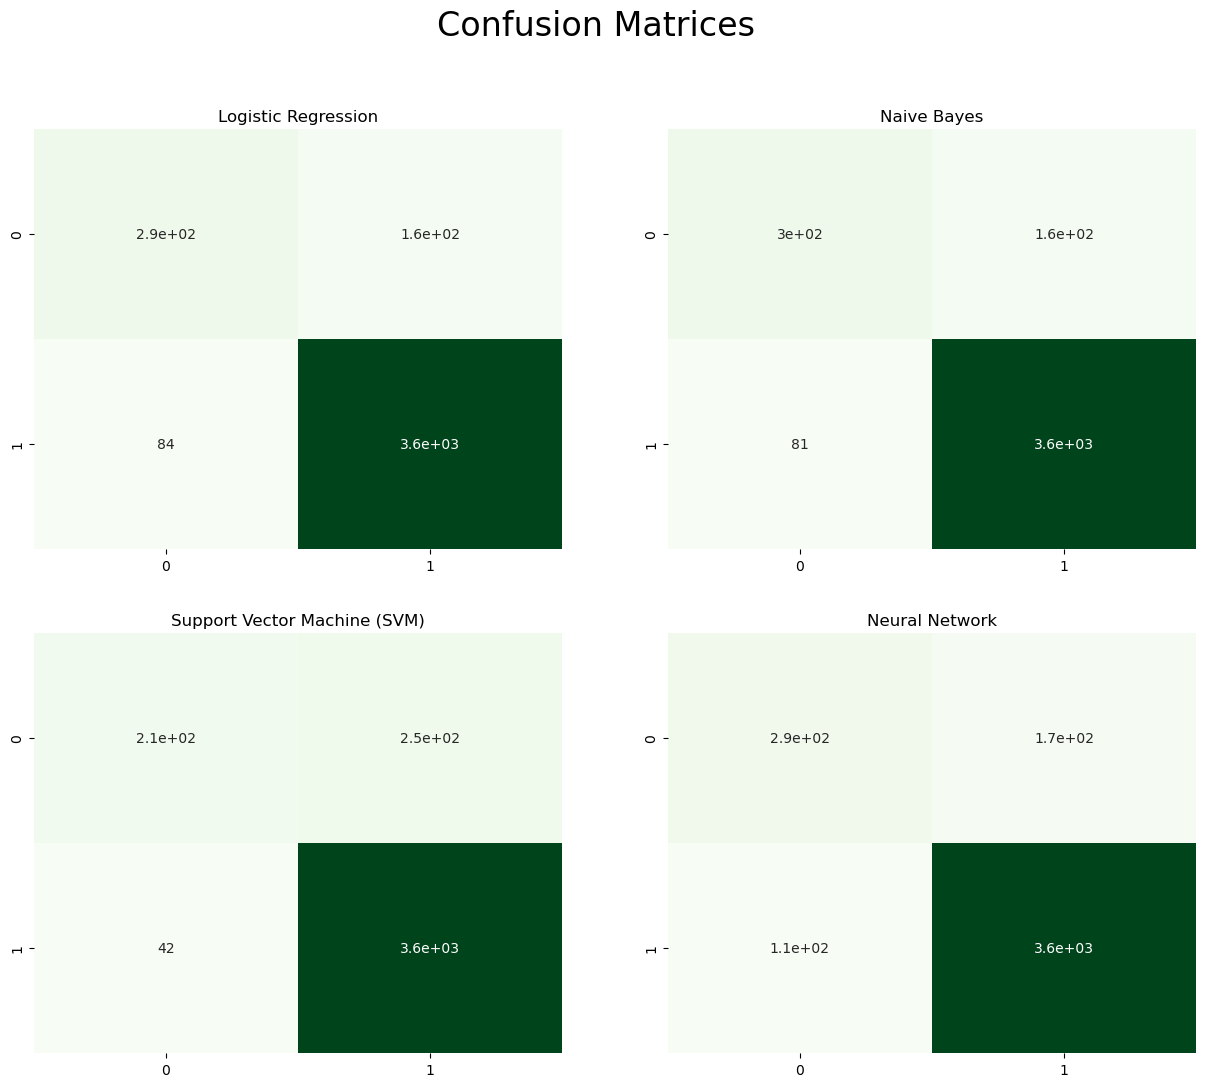

In [13]:
# preparation for the confusion matrix
lr_cm=confusion_matrix(y_test.values, lr.predict(X_test))
nb_cm=confusion_matrix(y_test.values, nb.predict(X_test))
svm_cm=confusion_matrix(y_test.values, svm.predict(X_test))
nn_cm=confusion_matrix(y_test.values, nn.predict(X_test))

plt.figure(figsize=(15,12))
plt.suptitle("Confusion Matrices",fontsize=24)

plt.subplot(2,2,1)
plt.title("Logistic Regression")
sns.heatmap(lr_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(2,2,2)
plt.title("Naive Bayes")
sns.heatmap(nb_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(2,2,3)
plt.title("Support Vector Machine (SVM)")
sns.heatmap(svm_cm, annot = True, cmap="Greens",cbar=False);

plt.subplot(2,2,4)
plt.title("Neural Network")
sns.heatmap(nn_cm, annot = True, cmap="Greens",cbar=False);

## <span id="15"></span> Precision - Recall - F1-Score

Last but not least, I examined *Precision*, *Recall* and *F1-score*. They are defined as

$$\textbf{Precision} = \dfrac{TP}{TP + FP} \;\;\;\;\;\;\;\;\;\; \textbf{Recall} = \dfrac{TP}{TP + FN}$$


$$\textbf{}$$


$$\textbf{F}_{1} = 2 \; \dfrac{Precision \; \times \;Recall}{Precision + Recall} = \dfrac{2 \; TP}{2 \; TP + FN + FP}$$ 

We have already examined ROC curves and confusion matrices but this is not enough for a final decision. In our case precision might be the best choice to evaluate our models beacause we want to determine negative comments with less mistakes (To compare precisions, we must look at the precision values for *True*.). However, if we predict positive comments false, it will not have a negative impact. Of course for some other purposes other evaluation metrics may be useful too.

In [14]:
print("Logistic Regression")
print(mt.classification_report(y_test, lr.predict(X_test)))
print("\n Naive Bayes")
print(mt.classification_report(y_test, nb.predict(X_test)))
print("\n Support Vector Machine (SVM)")
print(mt.classification_report(y_test, svm.predict(X_test)))
print("\n Neural Network")
print(mt.classification_report(y_test, nn.predict(X_test)))

Logistic Regression
              precision    recall  f1-score   support

       False       0.78      0.64      0.70       458
        True       0.96      0.98      0.97      3665

    accuracy                           0.94      4123
   macro avg       0.87      0.81      0.83      4123
weighted avg       0.94      0.94      0.94      4123


 Naive Bayes
              precision    recall  f1-score   support

       False       0.79      0.65      0.71       458
        True       0.96      0.98      0.97      3665

    accuracy                           0.94      4123
   macro avg       0.87      0.82      0.84      4123
weighted avg       0.94      0.94      0.94      4123


 Support Vector Machine (SVM)
              precision    recall  f1-score   support

       False       0.83      0.45      0.59       458
        True       0.94      0.99      0.96      3665

    accuracy                           0.93      4123
   macro avg       0.88      0.72      0.77      4123
weighted 

# <span id="16"></span> Conclusion
#### [Return Contents](#0)
<hr/>

When we look at the results of the all evaluation metrics in the *evaluating models section*, **Naive Bayes** and **Logistic Regression** gives the best results for our analysis. Thus, both of them are very effective at predicting sentiment. On the other hand, it seems that **Naive Bayes** takes less time and when we have a bigger dataset, this difference might increase and be an important advantage .

<b><font color="green">Thank you for reading my kernel </font></b> **and If you liked this kernel, please** <b><font color="red">do not forget to <b></font><font color="green">UPVOTE </font></b> 🙂